In [1]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import noisereduce as nr
import wave
import webrtcvad
import torch
from jupyterplot import ProgressPlot
from Audio_Sentiment_Analysis.utils.vscode_audio import Audio
torch.set_num_threads(1)
from sklearn import preprocessing

AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"

plt.rcParams['figure.dpi'] = 300

# Loading File and its Framing from IEMOCAP

Sample Rate: 16000 Hz


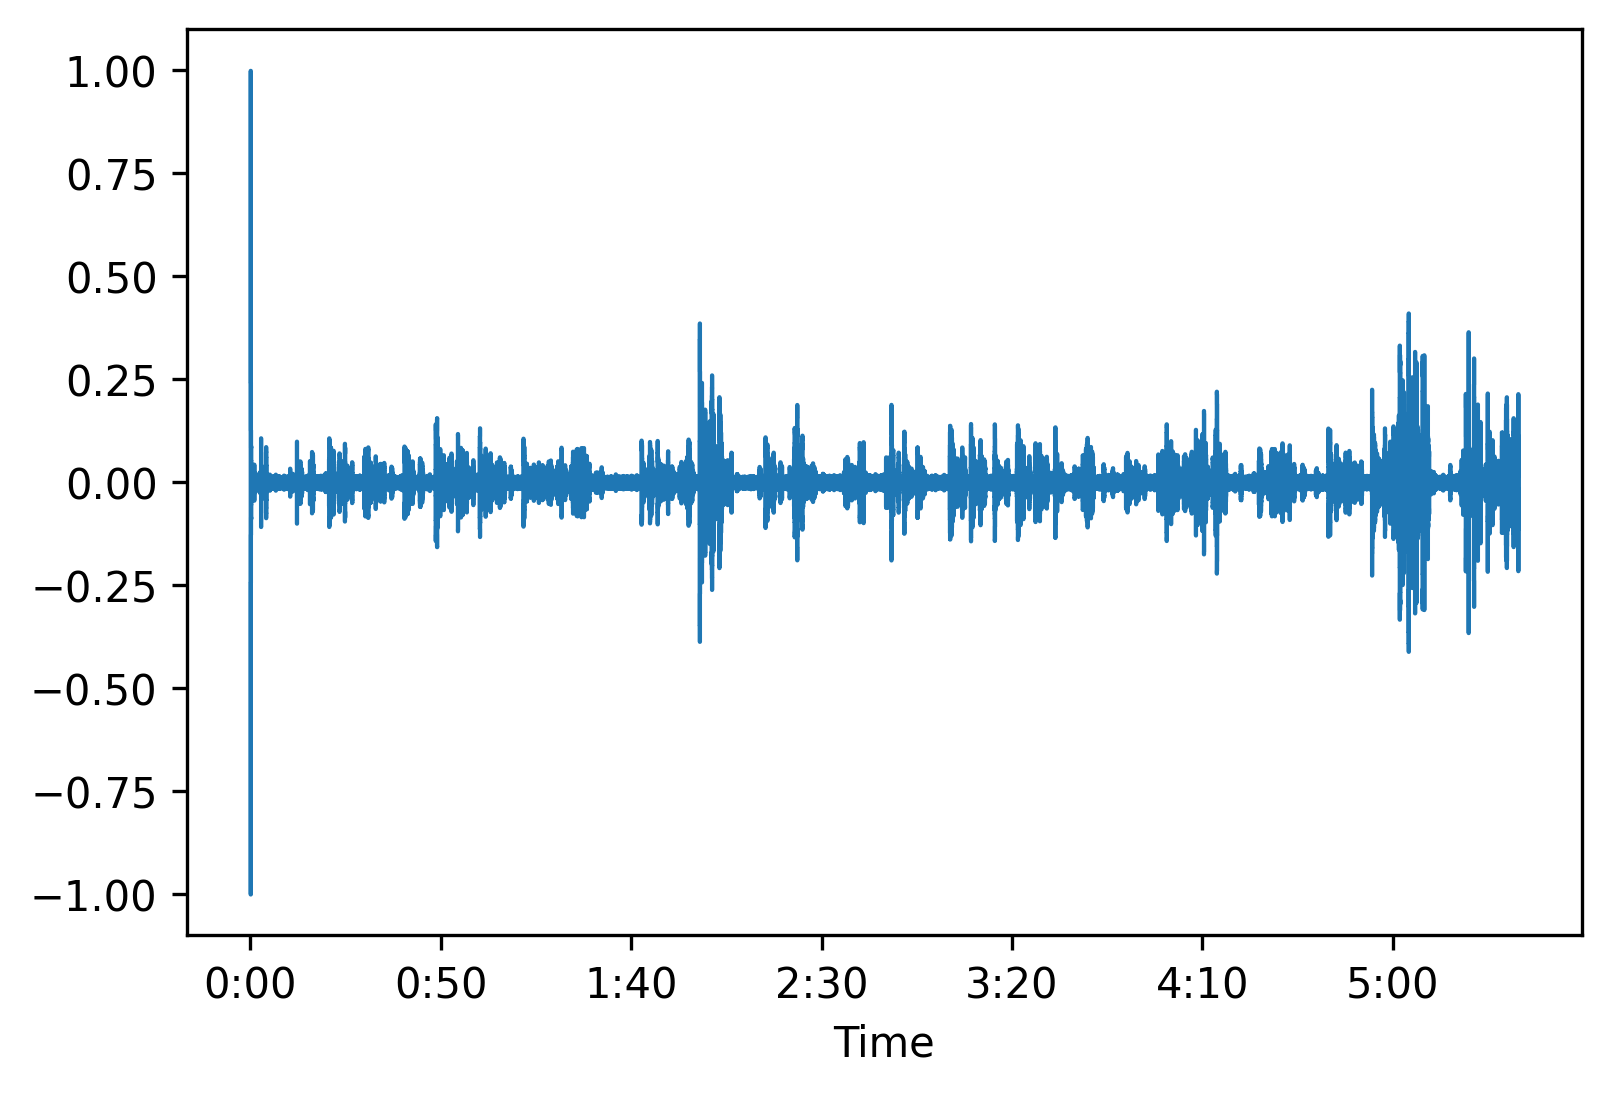

In [2]:
audio_file_test = AUDIO_DIR+'/Session1/dialog/wav/Ses01F_impro06.wav'
y, sr = librosa.load(audio_file_test, sr=16000)
y = preprocessing.minmax_scale(y, feature_range=(-1, 1))
librosa.display.waveshow(y, sr=sr)
print(f"Sample Rate: {sr} Hz")
plt.show()

In [3]:
all_voiced_frames = []
male_voiced_frames = []
female_voiced_frames = []
with open(AUDIO_DIR+'/Session1/dialog/EmoEvaluation/Ses01F_impro06.txt') as emotions_test_file:
    for line in emotions_test_file:
        if line[0] == '[':
            args = line.split()
            if 'M' == args[3][-4]:
                male_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
            else:
                female_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
            all_voiced_frames.append((float(args[0][1:]), float(args[2][:-1])))
all_voiced_frames.sort(key=lambda x: x[0])

In [4]:
# These have both female and male actors speech times
print(f"Number of separate actors voice frames: {len(all_voiced_frames)}")
print(all_voiced_frames)

Number of separate actors voice frames: 47
[(11.46, 14.74), (14.7939, 18.17), (18.49, 24.91), (24.02, 25.69), (25.12, 26.56), (26.07, 27.65), (28.97, 35.02), (34.45, 35.78), (36.07, 38.04), (39.6025, 46.29), (47.34, 59.38), (56.17, 57.49), (59.4525, 67.4525), (70.22, 80.13), (80.16, 87.74), (86.96, 88.63), (87.83, 93.67), (101.83, 116.91), (107.78, 109.27), (117.07, 126.04), (125.47, 127.19), (132.9575, 134.49), (134.4, 136.49), (135.96, 137.95), (137.09, 138.44), (138.0685, 141.05), (141.84, 149.4375), (144.09, 145.68), (155.07, 158.38), (158.08, 163.35), (165.61, 168.1), (167.64, 174.84), (174.39, 177.15), (176.35, 178.01), (182.56, 197.73), (197.755, 214.34), (217.5, 222.41), (219.73, 221.03), (223.52, 227.55), (229.08, 235.98), (237.53, 256.48), (255.35, 257.31), (262.99, 266.175), (266.55, 275.31), (275.38, 281.6), (282.01, 311.14), (308.24, 310.01)]


In [5]:
# Here we have both female and male actors speech times combined
# while not allowing differences between frames to be inferior than 1 second
min_frame_duration = 1 # duration in seconds

combined_voiced_frames = []
prev_start, prev_end = all_voiced_frames[0]
for start, end in all_voiced_frames[1:]:
    if start - prev_end <= min_frame_duration:
        prev_end = end
    else:
        combined_voiced_frames.append((prev_start, prev_end))
        prev_start, prev_end = start, end
combined_voiced_frames.append((prev_start, prev_end))
combined_voiced_frames.sort(key=lambda x: x[0])
print(f"Number of combined actors voice frames: {len(combined_voiced_frames)}")
print(combined_voiced_frames)

Number of combined actors voice frames: 17
[(11.46, 27.65), (28.97, 38.04), (39.6025, 46.29), (47.34, 57.49), (59.4525, 67.4525), (70.22, 93.67), (101.83, 109.27), (117.07, 127.19), (132.9575, 145.68), (155.07, 163.35), (165.61, 178.01), (182.56, 214.34), (217.5, 221.03), (223.52, 227.55), (229.08, 235.98), (237.53, 257.31), (262.99, 310.01)]


In [6]:
def display_graph(ax, title, data, legend_cols=3):
    ax.set_title(title)
    y_len = np.max(y) * 0.02
    y_space = np.max(y) * 0.1
    upper_y, middle_y, lower_y = np.max(y)+ y_space + y_len*3, np.max(y)+ y_space + y_len*2, np.max(y)+ y_space + y_len
    librosa.display.waveshow(y, sr=sr, label="Audio Waveform")
    start, end = data[0]
    ax.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='r', label="Voiced Frame")
    ax.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    ax.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    for start, end in data[1:]:
        ax.hlines(y=middle_y, xmin=start, xmax=end, linewidth=.7, color='r')
        ax.vlines(start, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
        ax.vlines(end, color='red', linewidth=.7, ymin=upper_y, ymax=lower_y)
    ax.legend(loc='lower center', bbox_to_anchor=(.5, -.28),
        ncol=legend_cols, fancybox=True, shadow=True)

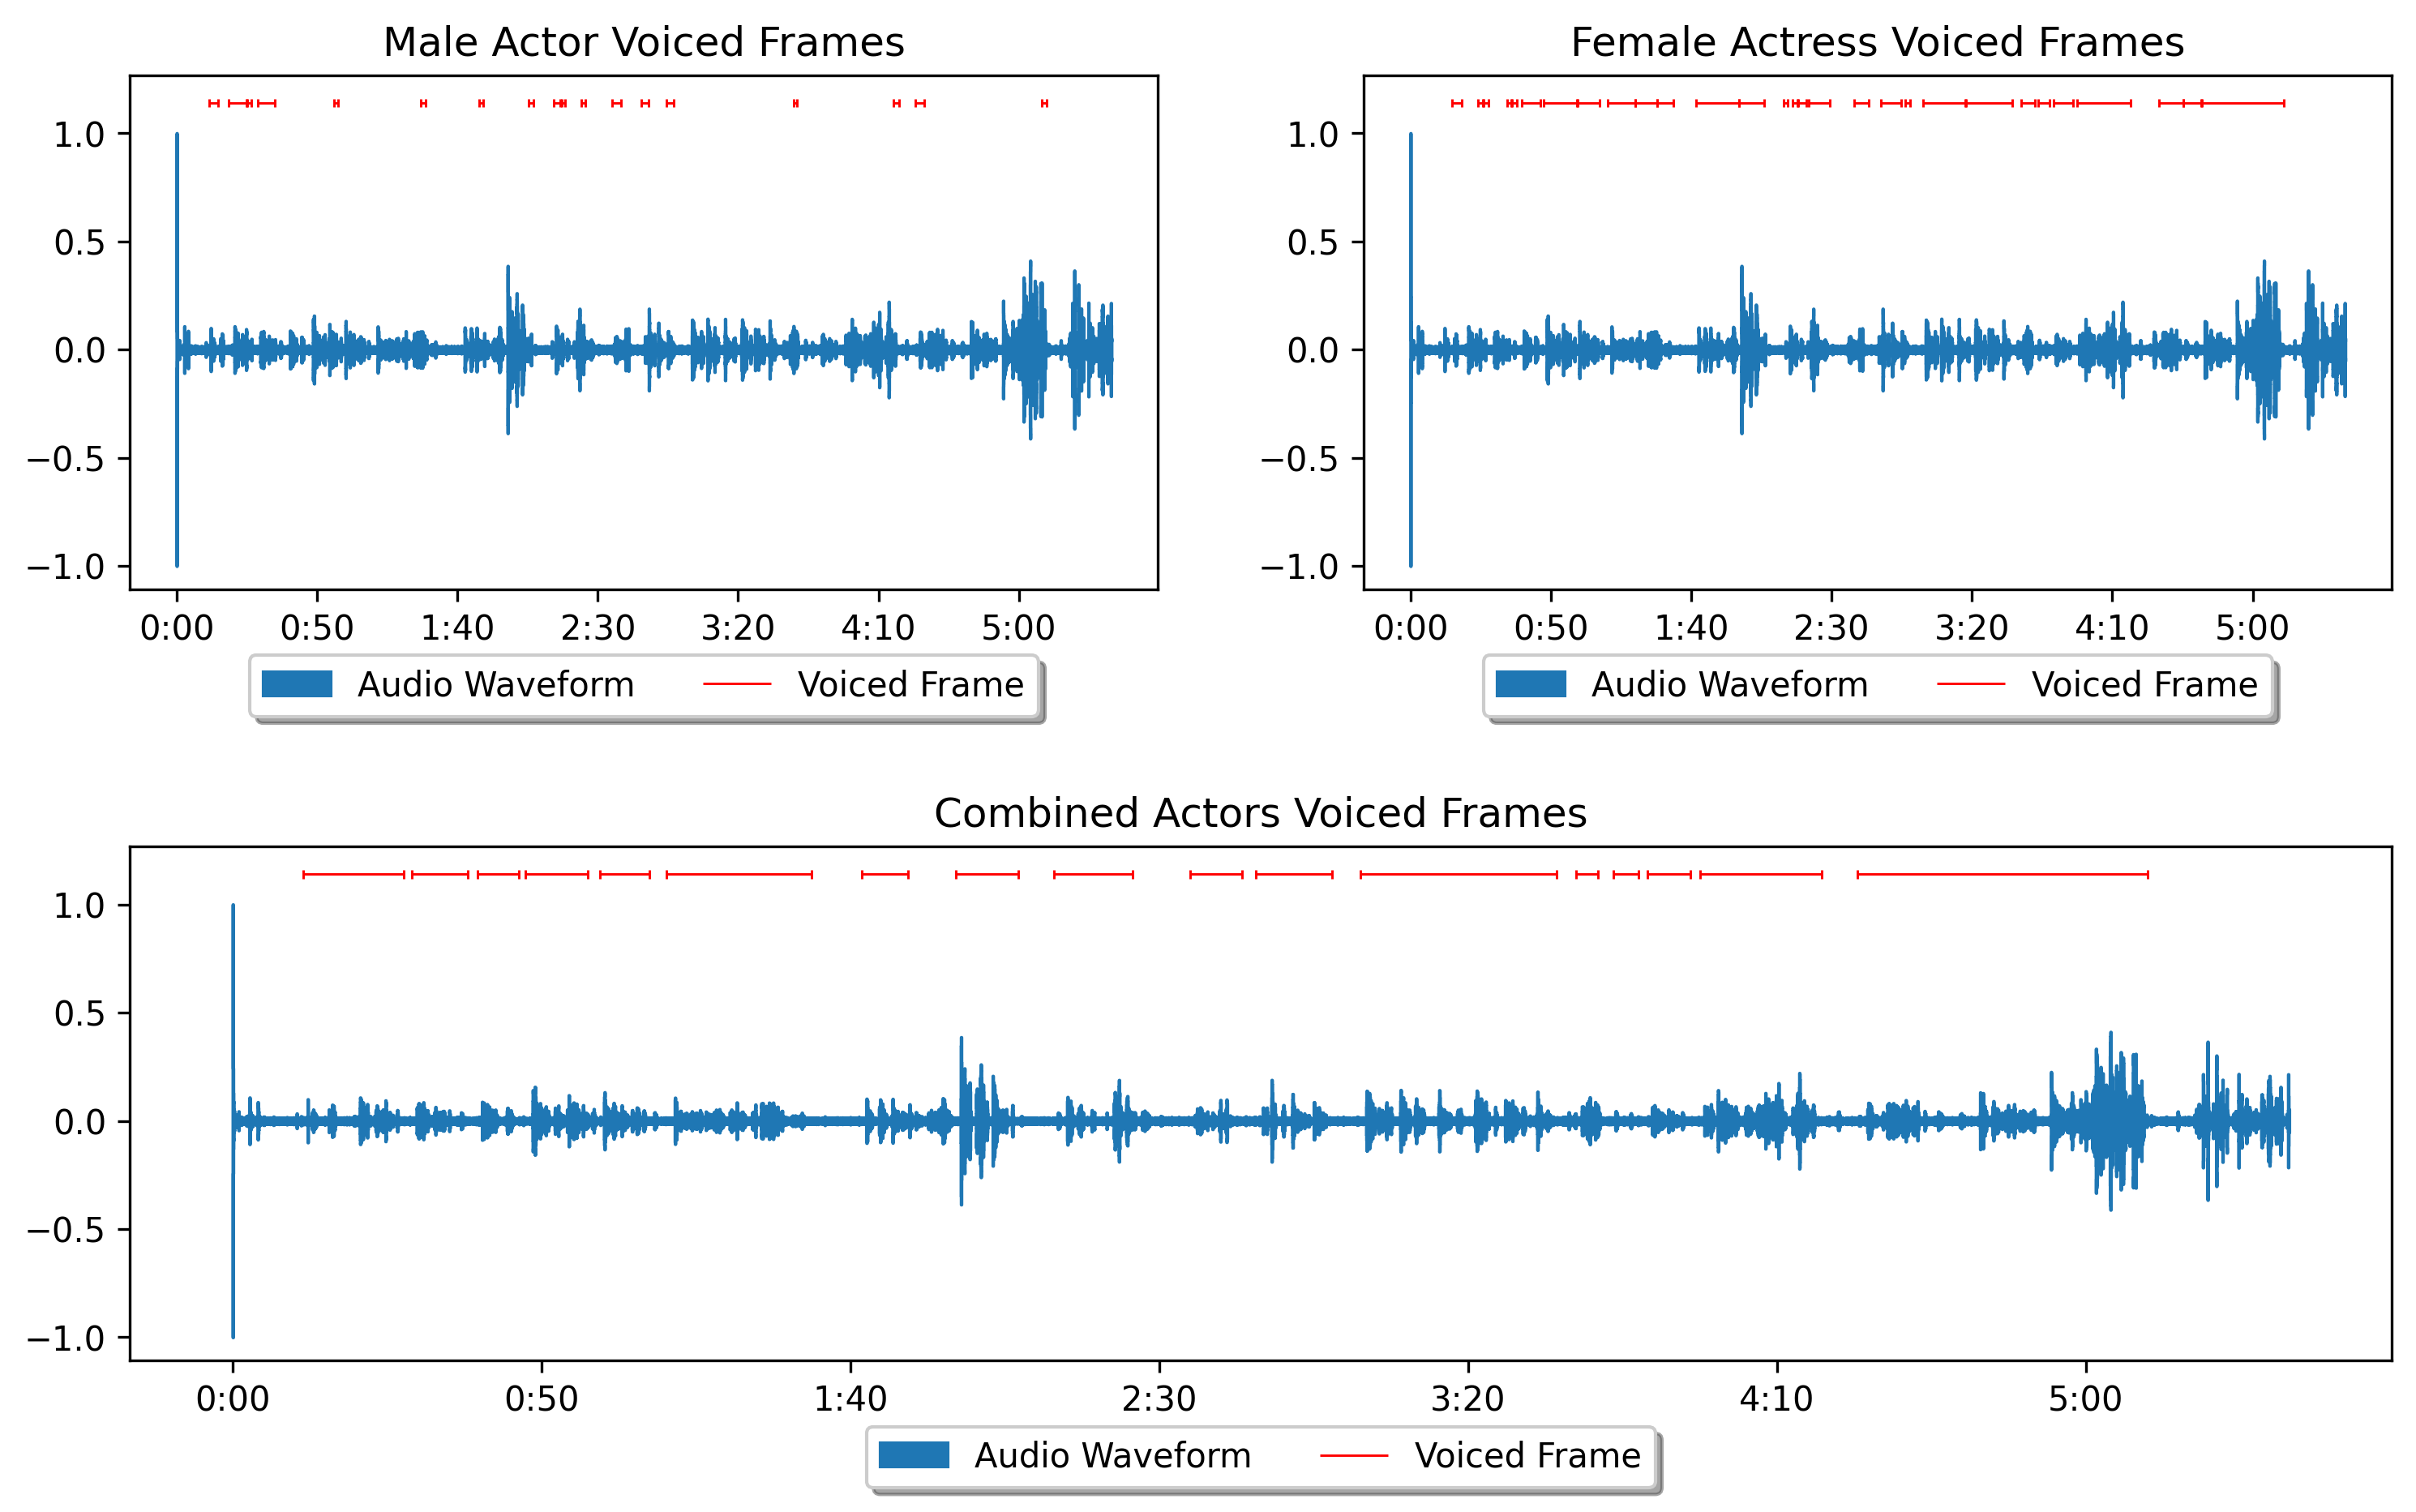

In [19]:
grid = plt.GridSpec(2, 2, wspace=.2, hspace=.5)
plt.figure(figsize=(12, 7))

display_graph(plt.subplot(grid[0, 0]), "Male Actor Voiced Frames", male_voiced_frames)
display_graph(plt.subplot(grid[0, 1]), "Female Actress Voiced Frames", female_voiced_frames)
display_graph(plt.subplot(grid[1, :]), "Combined Actors Voiced Frames", combined_voiced_frames)

plt.show()

# Framing

In [20]:
def read_wav_part_from_local(path: str, start_s: float, duration_s: float):
    with wave.open(path, mode='rb') as wavread:
        fs = wavread.getframerate()
        start = int(start_s * fs)
        duration = int(duration_s * fs)
        wavread.setpos(start)
        wav_bytes = wavread.readframes(duration)
        wav_array = np.frombuffer(wav_bytes, dtype='int32')
        return wav_array, fs

## Silero

In [21]:
def int2float32(sound):
    abs_max = np.abs(sound).max()
    sound = sound.astype('float32')
    if abs_max > 0:
        sound *= 1/abs_max
    sound = sound.squeeze()
    return sound

model, _ = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=False)

pp = ProgressPlot(plot_names=["Silero VAD"], line_names=["speech probabilities"], x_label="audio chunks")

silero_voiced_frames = []
silero_confidences = []
step = 0.3
min_confidence = 0.6
prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), step):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, step)
    if len(wav_array) >= 512:
        confidence = model(torch.from_numpy(int2float32(wav_array)), fs).item()

        silero_confidences.append(confidence)
        
        pp.update(confidence)

        end = start+step

        if confidence >= min_confidence:
            if prev_start == None:
                prev_start, prev_end = start, end
            elif prev_end == start or start - prev_end <= min_frame_duration:
                prev_end = end
            else:
                if prev_end - prev_start >= min_frame_duration:
                    silero_voiced_frames.append((prev_start, prev_end))
                prev_start, prev_end = start, end

if (len(silero_voiced_frames) and silero_voiced_frames[-1] != (prev_start, prev_end)) or ((not len(silero_voiced_frames)) and prev_end):
    if prev_end - prev_start > min_frame_duration:
        silero_voiced_frames.append((prev_start, prev_end))

Using cache found in C:\Users\Chico/.cache\torch\hub\snakers4_silero-vad_master


<IPython.core.display.Javascript object>

In [22]:
print("Execution time: 10 seconds")
print(f"Number of voice frames: {len(silero_voiced_frames)}")
print(silero_voiced_frames)

Execution time: 10 seconds
Number of voice frames: 20
[(0.6, 2.0999999999999996), (12.9, 17.7), (20.7, 27.6), (29.7, 38.699999999999996), (40.5, 67.5), (71.7, 72.89999999999999), (87.3, 90.0), (118.19999999999999, 130.20000000000002), (135.29999999999998, 139.5), (143.1, 150.3), (156.0, 160.20000000000002), (166.79999999999998, 181.8), (183.6, 209.70000000000002), (219.9, 222.0), (239.39999999999998, 260.4), (264.59999999999997, 274.8), (283.2, 290.1), (291.3, 292.5), (294.3, 312.0), (321.3, 333.0)]


## WebRTCVAD

In [23]:
# strict mode
vad = webrtcvad.Vad(3)

pp = ProgressPlot(plot_names=["WebRTCVAD"], line_names=["speech probabilities"], x_label="audio chunks")

webrtcvad_voiced_frames = []
webrtcvad_confidences = []

step = 0.02 # duration in seconds
prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), step):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, step)
    if webrtcvad.valid_rate_and_frame_length(fs, len(wav_array)):
        confidence = vad.is_speech(wav_array, fs)
        webrtcvad_confidences.append(confidence)

        pp.update(confidence)

        end = start+step

        if confidence == 1:
            if prev_start == None:
                prev_start, prev_end = start, end
            elif prev_end == start or start - prev_end <= min_frame_duration:
                prev_end = end
            else:
                if prev_end - prev_start >= min_frame_duration:
                    webrtcvad_voiced_frames.append((prev_start, prev_end))
                prev_start, prev_end = start, end

if (len(webrtcvad_voiced_frames) and webrtcvad_voiced_frames[-1] != (prev_start, prev_end)) or ((not len(webrtcvad_voiced_frames)) and prev_end):
    if prev_end - prev_start >= min_frame_duration:
        webrtcvad_voiced_frames.append((prev_start, prev_end))

<IPython.core.display.Javascript object>

In [24]:
print("Execution time: 11 seconds")
print(f"Number of voice frames: {len(webrtcvad_voiced_frames)}")
print(webrtcvad_voiced_frames)

Execution time: 11 seconds
Number of voice frames: 36
[(20.6, 22.02), (23.36, 24.96), (29.82, 31.68), (32.92, 35.220000000000006), (40.38, 42.42), (48.58, 50.86000000000001), (54.160000000000004, 56.900000000000006), (60.14, 66.86), (71.58, 79.08), (80.72, 82.67999999999999), (84.12, 88.84), (104.66, 108.53999999999999), (114.28, 115.5), (117.88, 126.42), (142.68, 146.24), (156.08, 158.78), (159.88, 161.12), (166.84, 168.94000000000003), (171.54, 173.0), (183.54, 187.68), (189.06, 192.8), (195.26, 196.70000000000002), (201.18, 204.56), (206.0, 209.16000000000003), (218.44, 221.22000000000003), (238.28, 242.82000000000002), (245.02, 250.88000000000002), (252.6, 254.58), (267.9, 271.21999999999997), (282.92, 283.94), (294.40000000000003, 296.3), (297.64, 306.58), (307.68, 308.96), (318.84000000000003, 319.94), (321.14, 326.71999999999997), (328.46, 332.97999999999996)]


## Results Overview

C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Chico\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


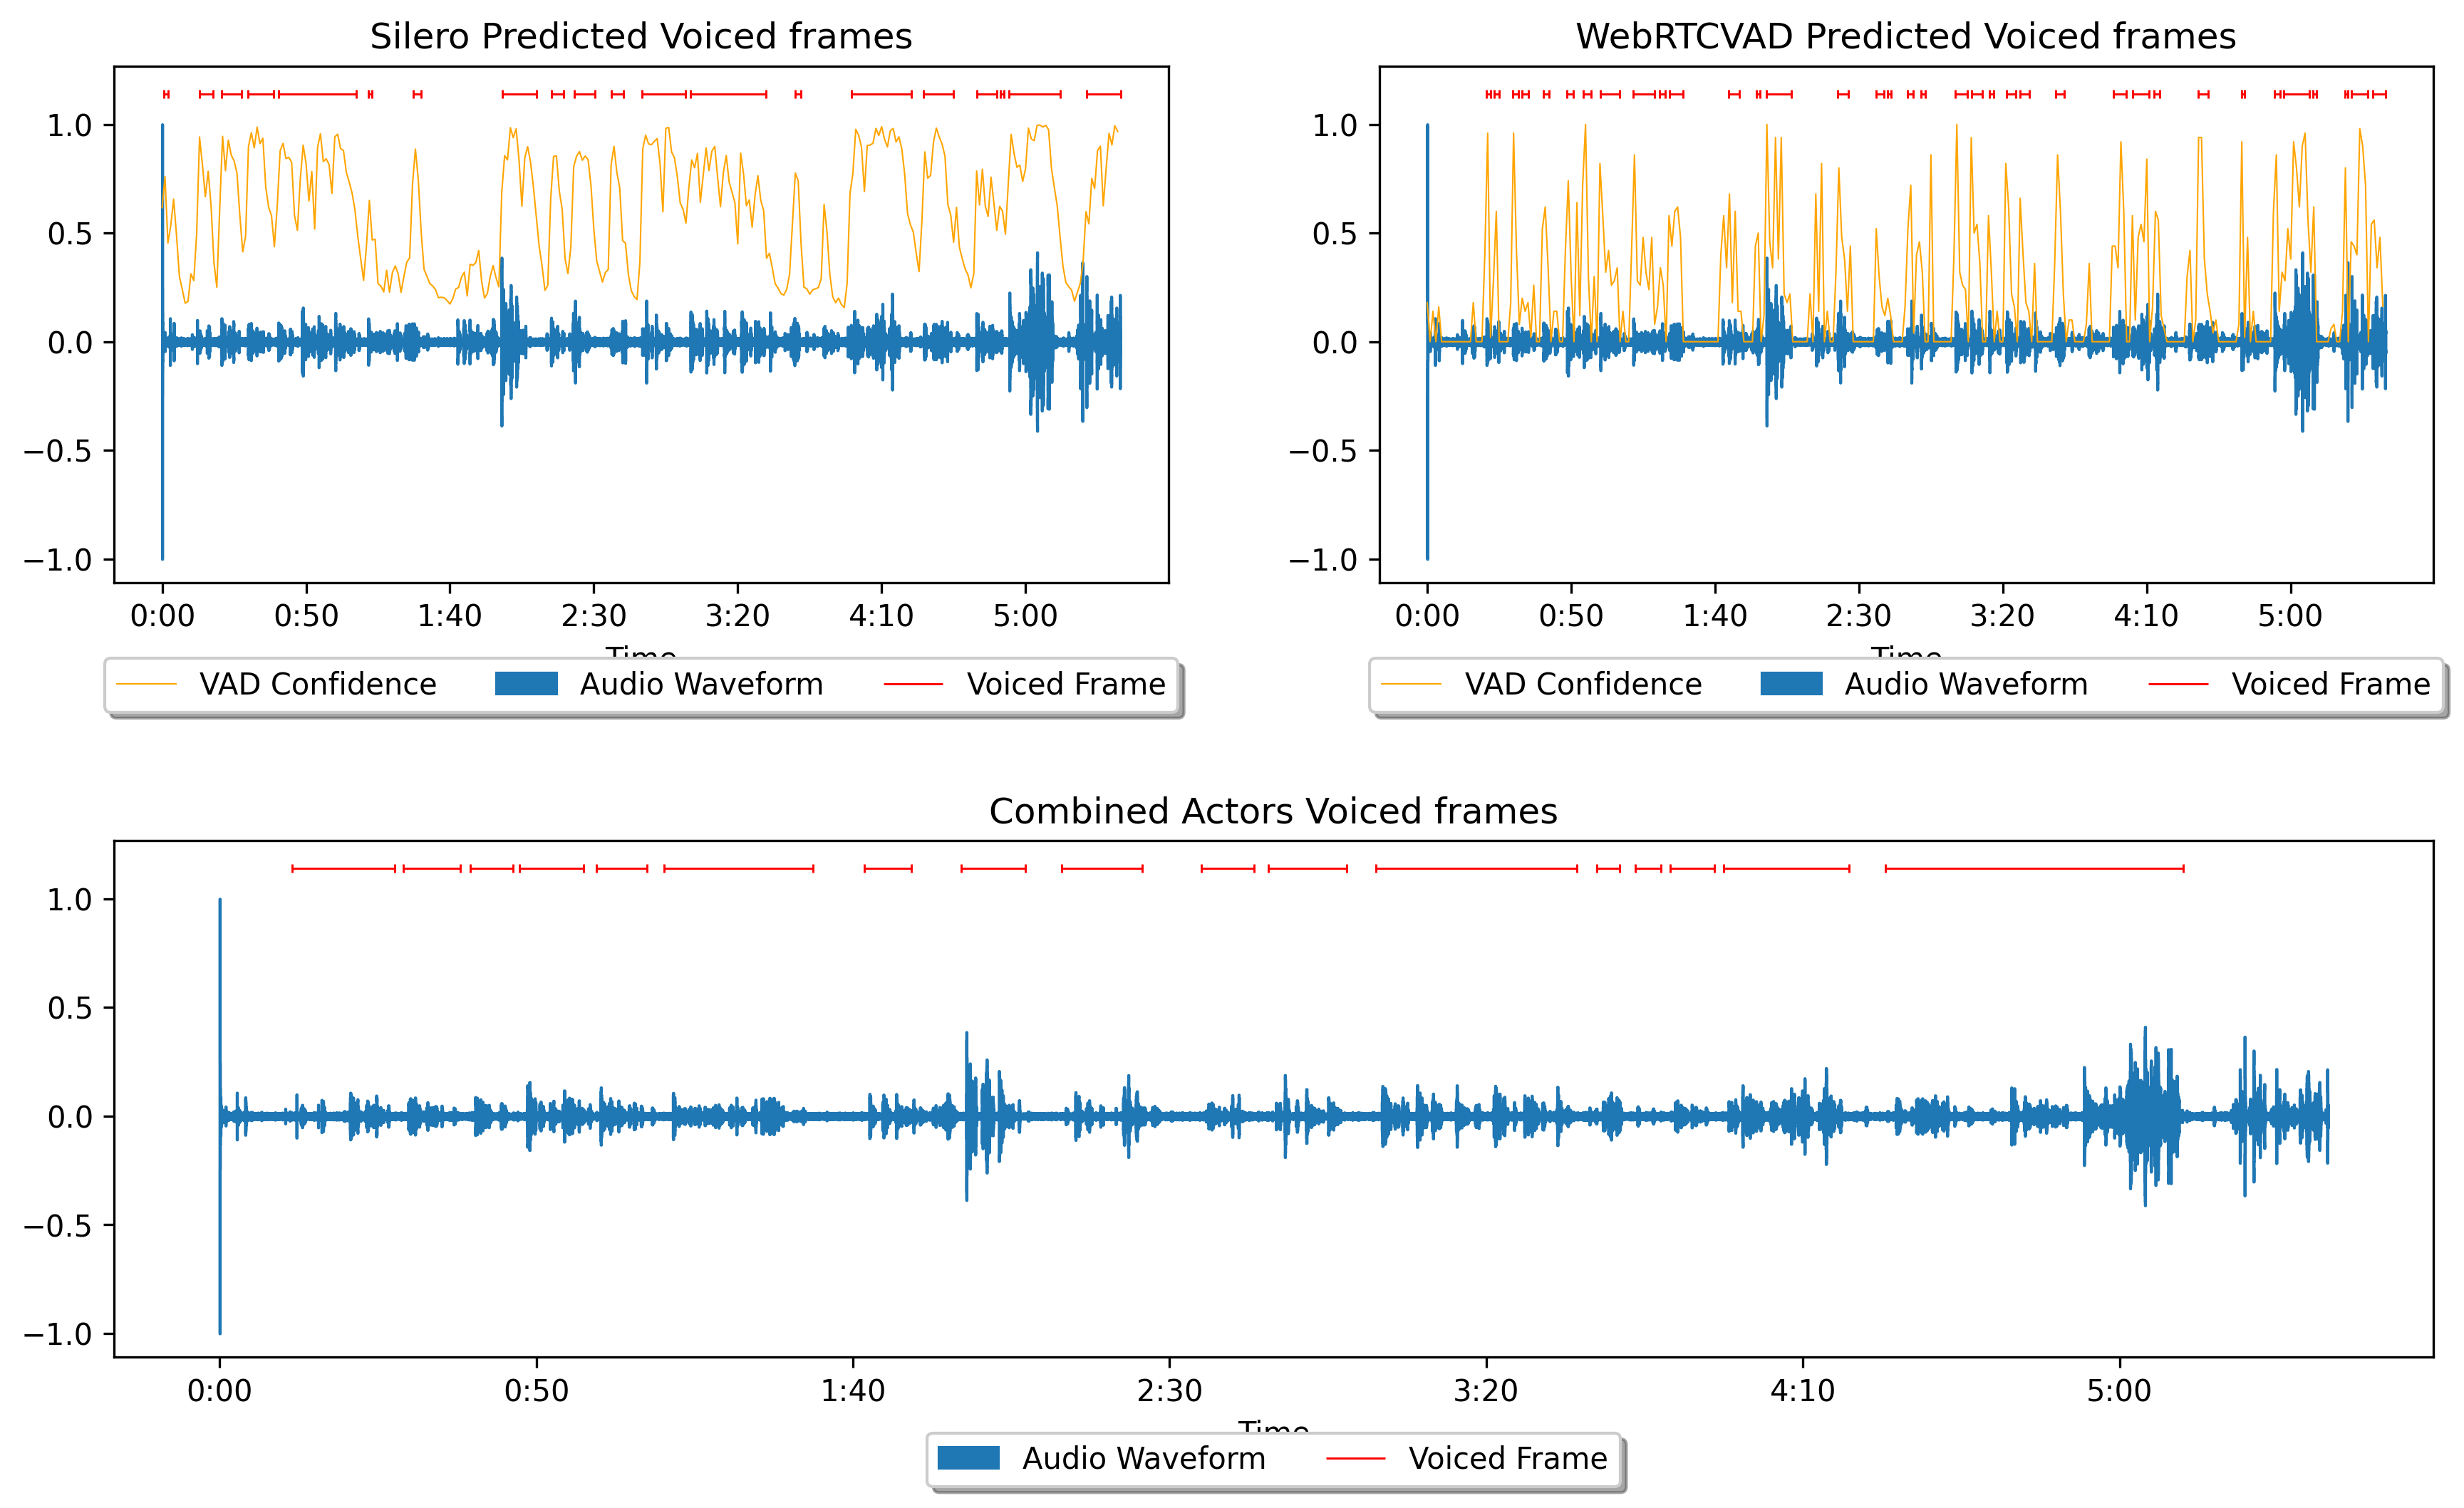

In [28]:
grid = plt.GridSpec(2, 2, wspace=.2, hspace=.5)
plt.figure(figsize=(14, 8))

display_graph(plt.subplot(grid[1, :]), "Combined Actors Voiced frames", combined_voiced_frames)

ax = plt.subplot(grid[0, 0])
plt_confidences = []
sum_i = 0
for i in range(0, len(silero_confidences), 3):
    if i > len(silero_confidences):
        break
    if not (i % 9):
        i += sum_i
        plt_confidences.append(np.mean(silero_confidences[i:i+4]))
        sum_i += 1
    else:
        i += sum_i
        plt_confidences.append(np.mean(silero_confidences[i:i+3]))
ax.plot(plt_confidences, label="VAD Confidence", color="orange", linewidth=0.5)
display_graph(ax, "Silero Predicted Voiced frames", silero_voiced_frames, 4)

ax = plt.subplot(grid[0, 1])
plt_confidences = []
for i in range(0, len(webrtcvad_confidences), 50):
    plt_confidences.append(np.mean(webrtcvad_confidences[i:i+50]))
ax.plot(plt_confidences, label="VAD Confidence", color="orange", linewidth=0.5)
display_graph(ax, "WebRTCVAD Predicted Voiced frames", webrtcvad_voiced_frames, 4)

plt.show()

In [14]:
Audio(y[int(silero_voiced_frames[1][0]*sr):int(silero_voiced_frames[1][1]*sr)], sr)

In [15]:
Audio(y[int(webrtcvad_voiced_frames[0][0]*sr):int(webrtcvad_voiced_frames[0][1]*sr)], sr)

## Testing with Noise Reduction

In [31]:
model, _ = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=False)

pp = ProgressPlot(plot_names=["Silero VAD"], line_names=["speech probabilities"], x_label="audio chunks")

denoised_silero_voiced_frames = []
denoised_silero_confidences = []
step = 0.032 # duration in seconds
min_confidence = 0.8
prev_start, prev_end = None, None
for start in np.arange(0, librosa.get_duration(y=y, sr=sr), step):
    wav_array, fs = read_wav_part_from_local(audio_file_test, start, step)
    wav_array = nr.reduce_noise(
        y=wav_array, sr=fs, n_fft=2048, hop_length=512, prop_decrease=.75, time_constant_s=1
    )
    if len(wav_array) == 512:
        confidence = model(torch.from_numpy(int2float32(wav_array)), fs).item()

        denoised_silero_confidences.append(confidence)
        
        pp.update(confidence)

        end = start+step

        if confidence >= min_confidence:
            if prev_start == None:
                prev_start, prev_end = start, end
            elif prev_end == start or start - prev_end <= min_frame_duration:
                prev_end = end
            else:
                if prev_end - prev_start >= min_frame_duration:
                    denoised_silero_voiced_frames.append((prev_start, prev_end))
                prev_start, prev_end = start, end

if (len(denoised_silero_voiced_frames) and denoised_silero_voiced_frames[-1] != (prev_start, prev_end)) or ((not len(denoised_silero_voiced_frames)) and prev_end):
    if prev_end - prev_start > min_frame_duration:
        denoised_silero_voiced_frames.append((prev_start, prev_end))

Using cache found in C:\Users\Chico/.cache\torch\hub\snakers4_silero-vad_master


<IPython.core.display.Javascript object>

In [32]:
print("Execution time: 75 seconds")
print(f"Number of voice frames: {len(denoised_silero_voiced_frames)}")
print(denoised_silero_voiced_frames)

Execution time: 75 seconds
Number of voice frames: 7
[(20.704, 26.080000000000002), (29.92, 34.687999999999995), (41.44, 43.199999999999996), (48.64, 51.104), (55.2, 56.768), (299.936, 309.536), (329.728, 332.128)]


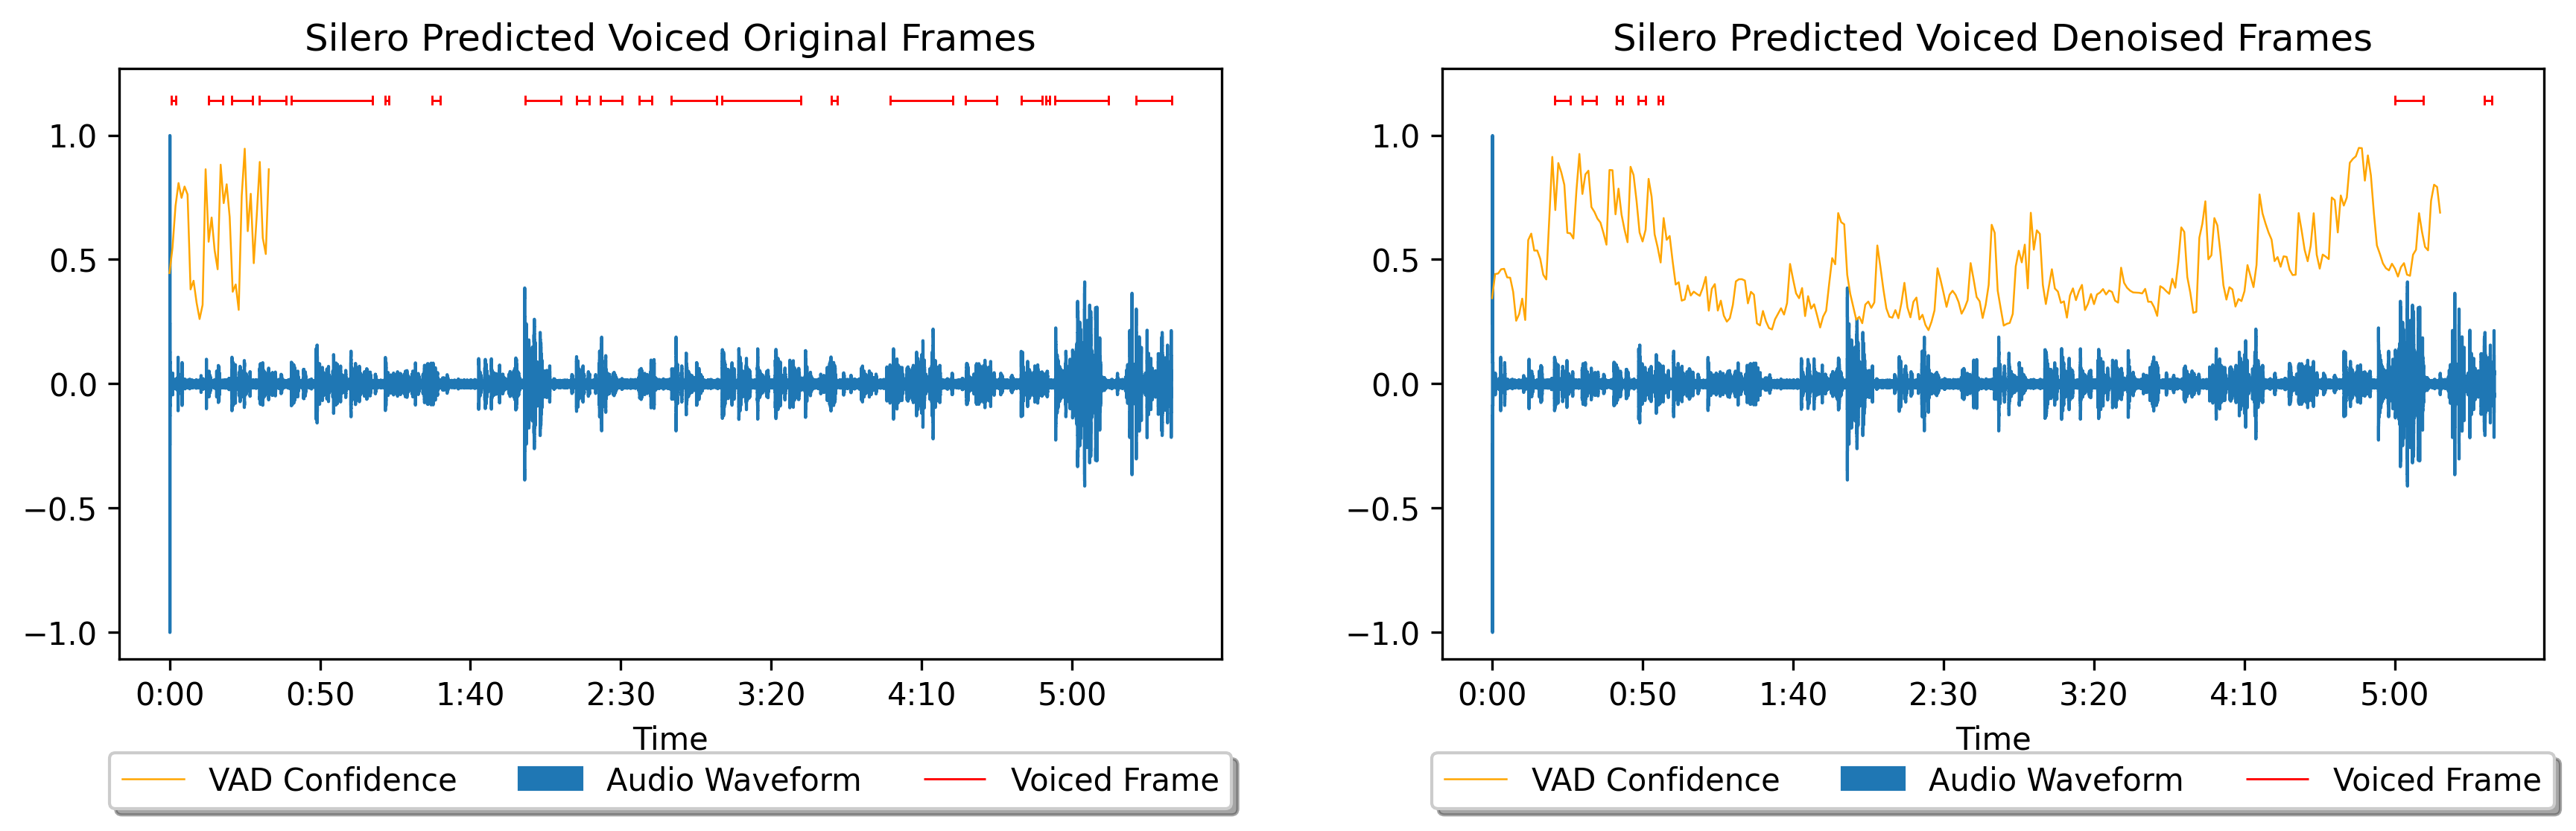

In [38]:
grid = plt.GridSpec(1, 2, wspace=.2, hspace=.5)
plt.figure(figsize=(14, 3.5))

ax = plt.subplot(grid[0, 0])
plt_confidences = []
for i in range(0, len(silero_confidences), 33):
    plt_confidences.append(np.mean(silero_confidences[i:i+33]))
ax.plot(plt_confidences, label="VAD Confidence", color="orange", linewidth=0.6)
display_graph(ax, "Silero Predicted Voiced Original Frames", silero_voiced_frames, 4)


ax = plt.subplot(grid[0, 1])
plt_confidences = []
for i in range(0, len(denoised_silero_confidences), 33):
    plt_confidences.append(np.mean(denoised_silero_confidences[i:i+33]))
ax.plot(plt_confidences, label="VAD Confidence", color="orange", linewidth=0.6)
display_graph(ax, "Silero Predicted Voiced Denoised Frames", denoised_silero_voiced_frames, 4)

plt.show()